## Анализ полученных данных

Статистика по вакансиям для удобного отображения вынесена в отдельную тетрадку.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
import numpy as np
import re

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

sns.set()

C:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


### Загрузка данных

In [476]:
df = pd.read_csv('hh_results.csv')
df.head()

,Ids,Employer,Name,Salary,From,To,Experience,Schedule,Keys,Description
0,50880086,Домклик,Data analyst/data engineer,False,NaN,NaN,От 1 года до 3 лет,Полный день,"['Python', 'SQL', 'PostgreSQL', 'Базы данных',...",Мы - это продуктовая IT компания по созданию h...
1,50439267,NXP Semiconductors,Data Engineer,False,NaN,NaN,От 1 года до 3 лет,Полный день,"['Python', 'Linux', 'English', 'TCL', 'Data En...",NXP Semiconductors N.V. (NASDAQ: NXPI) enables...
2,51056512,ПИК-БРОКЕР,Data Engineer,True,150000.0,250000.0,От 1 года до 3 лет,Полный день,"['Python', 'SQL', 'PostgreSQL', 'Git', 'Airflow']",Мы - ПИК-Брокер - молодая и очень динамично ра...
3,50657338,COMTEK Inc.,Data Scientist,False,NaN,NaN,От 3 до 6 лет,Полный день,"['Python', 'SQL', 'Power BI', 'Английский язык...",Подбираем команду для крупной американской ком...
4,50439196,Медиа Бизнес Солюшенс,Data scientist,False,NaN,NaN,От 1 года до 3 лет,Полный день,"['Python', 'PostgreSQL', 'Tensorflow', 'sklear...","М3 — компания, которая занимается развитием ци..."


### Количество вакансий

In [477]:
df['Name'] = df.Name.str.lower()

In [478]:
df['Name'] = df.Name.apply(lambda x:'data engineer' if 'data engineer' in x else x)

In [479]:
df['Name'] = df.Name.apply(lambda x:'data scientist' if 'data scientist' in x else x)

In [480]:
for i in ('product analyst', 'аналитик данных', 'продуктовый аналитик', 'data analyst'):
    df['Name'] = df.Name.apply(lambda x:'data analyst' if i in x else x)

In [481]:
da_de_ds = df[
              (df.Name.str.contains('data engineer')) | \
              (df.Name.str.contains('data analyst')) | \
              (df.Name.str.contains('data scientist'))  
             ]

In [482]:
da_de_ds.Name.value_counts()

data engineer     303
data scientist    235
data analyst      231
Name: Name, dtype: int64

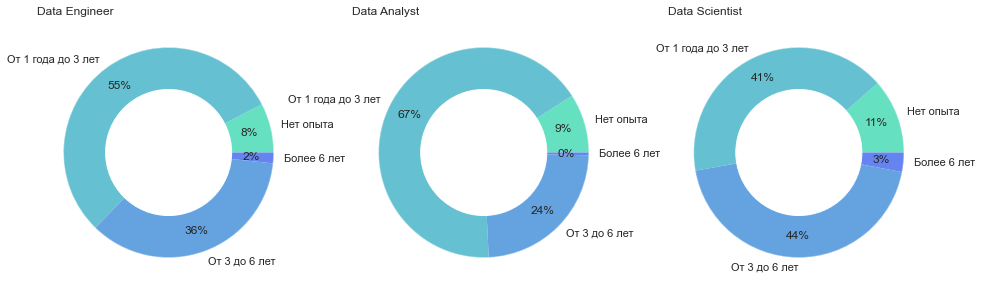

In [483]:
def get_level_stats(data, category):
    level_stats ={
        'Нет опыта': df[(df.Name.str.contains(category)) & (df.Experience == 'Нет опыта')].Ids.count(),
        'От 1 года до 3 лет': df[(df.Name.str.contains(category)) & (df.Experience == 'От 1 года до 3 лет')].Ids.count(),
        'От 3 до 6 лет': df[(df.Name.str.contains(category)) & (df.Experience == 'От 3 до 6 лет')].Ids.count(),
        'Более 6 лет': df[(df.Name.str.contains(category)) & (df.Experience == 'Более 6 лет')].Ids.count(),
    }
    return level_stats
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 10))

centre_circle = plt.Circle((0,0),0.6, fc='white')
centre_circle1 = plt.Circle((0,0),1, fc='white', alpha= 0.4)
level_stats = get_level_stats(df, 'data engineer')
ax1.pie(level_stats.values(), labels=level_stats.keys(), pctdistance=0.79,
        colors=sns.color_palette('winter_r', 4), autopct='%1.f%%', wedgeprops = {'linewidth': 0})
ax1.add_artist(centre_circle)
ax1.add_artist(centre_circle1)
ax1.set_title('Data Engineer', size=12, loc='left')

centre_circle = plt.Circle((0,0),0.6, fc='white')
centre_circle1 = plt.Circle((0,0),1, fc='white', alpha= 0.4)
level_stats = get_level_stats(df, 'data analyst')
ax2.pie(level_stats.values(), labels=level_stats.keys(), pctdistance=0.79,
        colors=sns.color_palette('winter_r', 4), autopct='%1.f%%', wedgeprops = {'linewidth': 0})
ax2.add_artist(centre_circle)
ax2.add_artist(centre_circle1)
ax2.set_title('Data Analyst', size=12, loc='left')


centre_circle = plt.Circle((0,0),0.6, fc='white')
centre_circle1 = plt.Circle((0,0),1, fc='white', alpha= 0.4)
level_stats = get_level_stats(df, 'data scientist')
ax3.pie(level_stats.values(), labels=level_stats.keys(), pctdistance=0.79,
        colors=sns.color_palette('winter_r', 4), autopct='%1.f%%', wedgeprops = {'linewidth': 0})
ax3.add_artist(centre_circle)
ax3.add_artist(centre_circle1)
ax3.set_title('Data Scientist', size=12, loc='left')
plt.show()

### Зарплаты в Data Science

In [484]:
salary = da_de_ds[(da_de_ds.From.notnull()) | (da_de_ds.To.notnull())]

In [485]:
salary = salary[salary['Experience'] != 'Более 6 лет'].sort_values(by='Experience')

In [486]:
salary['mean_salary'] = salary[['From', 'To']].mean(axis=1)

In [487]:
dis = salary[['Name', 'Experience']].append(salary[['Name', 'Experience']])
dis['Salary'] = salary[['From', 'To']].melt()['value'].tolist()

In [488]:
fig = px.box(dis, x="Experience", y="Salary", color='Name', labels={
             "Salary": "Уровень зарплат в тыс. рублях",
             "Experience": "Уровень",
             "Name": "Специальность"
         }, title = 'Распределение зарплат по грейдам')
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,)
fig.show()

### Анализ навыков

In [489]:
skills = {
    'Agile': {'\Wagile\W'},
    'BI': {'\Wbusiness\W', 'bi'},
    'English': {'\Wenglish\W'},
    'TensorFlow': {'tensorflow', '\Wtf\W', 'тензорфлоу'},
    'PyTorch': {'pytorch', 'пайторч'},
    'Keras': {'keras', 'керас'},
    'Python': {'python', 'питон', 'пайтон'},
    'Pandas/numpy': {'\Wpandas\W', '\Wnumpy\W'},
    'R': {'\Wr\W'},
    'SQL': {'sql', 'ms sql'},
    'Scala': {'scala', 'скала'},
    'Java': {'java', 'джава'},
    'Julia': {'julia', 'джули[ая]'},
    'Go': {'\Wgo\W'},
    'C++': {'c\+\+'},
    'C#': {'c#', 'шарп'},
    'Linux': {'bash', 'баш', 'linux', 'линукс'},
    'JS': {'\Wjs\W', 'java\W?script'},
    'Matlab': {'matlab', 'матлаб'},
    'Django': {'django', 'джанго'},
    'Flutter': {'flutter', 'флатт?ер'},
    'Flask': {'flask', 'фласк'},
    'Spring': {'spring'},
    'Git': {'git', 'github', 'bitbucket', 'gitlab', 'гит', 'гитхаб', 'битбакет', 'гитлаб'},
    'Docker': {'docker', 'докер'},
    'Kubernetes': {'kubernetes', 'кубернетес'},
    'Openshift': {'openshift'},
    'Grafana': {'grafana', 'графан'},
    'Power BI': {'power bi', 'powerbi'},
    'Tableau': {'tableau', 'табло'},
    'Airflow': {'airflow', 'а[э]ирфлоу'},
    'Prometheus': {'prometheus', 'прометеус'},
    'Redshift': {'redshift'},
    'HDFS': {'hdfs'},
    'MapReduce': {'mapreduce'},
    'Spark': {'spark', 'спарк'},
    'Hive': {'hive'},
    'Azure': {'azure'},
    'Hadoop': {'hadoop', 'хадуп'},
    'Kafka': {'kafka', 'кафк[ау]'},
    'RabbitMQ': {'rabbit', 'кролик'},
    'MongoDB': {'mongo.?db'},
    'Firebase': {'firebase'},
    'Cassandra': {'cassandra'},
    'Redis': {'redis'},
    'Redshift': {'redshift'},
    'BigQuery': {'bigquery'},
    'Excel': {'\Wexcel\W', '\Wэксел\W'},
    'Clickhouse': {'clickhouse', 'кликхау[сз]'},
    'XGBoost': {'xgboost', '\Wxgb\W'},
    'LightGBM': {'lightgbm', '\Wlgb\W'},
    'CatBoost': {'catboost'},
    'Scikit-learn': {'scikit', 'sklearn'},
    'SciPy': {'scipy'},
    'MLflow': {'mlflow', 'ml flow'},
}

In [490]:
def get_keyword_df(df, keywords):
    for keyword, keywords_to_search in keywords.items():
        keywords_regex = '|'.join(keywords_to_search)
        df[keyword] = df['Keys'].str.contains(keywords_regex, regex=True)
    keywords_df = pd.DataFrame(columns=['keyword', 'number'])
    for keyword in list(keywords.keys()):
        keywords_df = keywords_df.append({'keyword': keyword, 'number': len(df[df[keyword]])}, ignore_index=True)
    keywords_df = keywords_df.sort_values(by=['number'], ascending=False).reset_index(drop=True)
    keywords_df['perc'] = keywords_df['number'] / len(df) * 100
    return keywords_df

In [491]:
da_de_ds['Keys'] = df.Keys.str.lower()
keyword_df = get_keyword_df(da_de_ds, skills).head(25)
skills_list = [i for i in keyword_df['keyword'].values]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(61.125, 0.5, '')

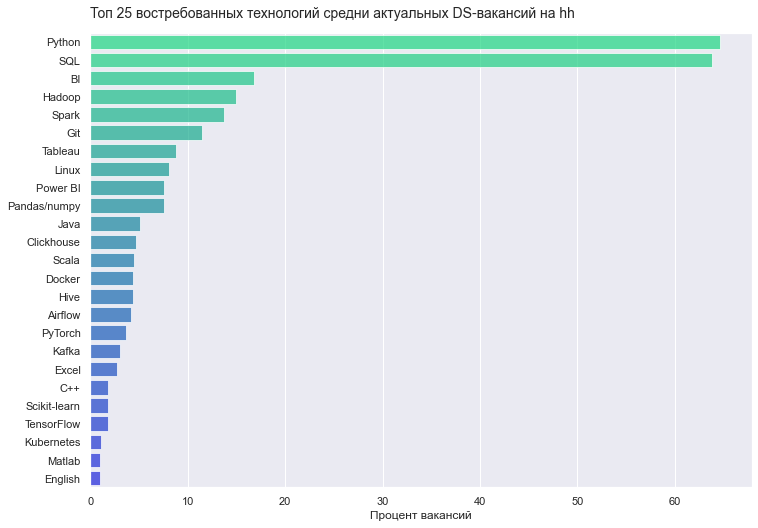

In [492]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))
fig.tight_layout(w_pad=5)

sns.barplot(ax = ax, data=keyword_df, x='perc', y='keyword', palette=sns.color_palette('winter_r', 25), alpha=0.7)
ax.set_title(label=f'Топ 25 востребованных технологий средни актуальных DS-вакансий на hh', loc='left', size=14, pad=15)
ax.set_xlabel('Процент вакансий')
ax.set_ylabel('')

In [531]:
def get_keyword_df_for_salary(df, keywords):
    for keyword, keywords_to_search in keywords.items():
        keywords_regex = '|'.join(keywords_to_search)
        df[keyword] = df['Keys'].str.contains(keywords_regex, regex=True)
    keywords_df = df
    X = df.iloc[:, 11:].astype(int)
    y = df.iloc[:,10]
    return df.iloc[:, 10:].astype(int)

In [532]:
hstack = get_keyword_df_for_salary(salary, skills)

In [524]:
model = Ridge(alpha=0, random_state=255)
model.fit(hstack[0], hstack[1])

Ridge(alpha=0, random_state=255)

In [525]:
model.coef_

array([ 1.38106911e-13, -1.72388809e-11,  1.22960992e-11,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  6.37500000e+04,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -6.64945049e+04,
        6.37500000e+04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [533]:
hstack

,mean_salary,Agile,BI,English,TensorFlow,PyTorch,Keras,Python,Pandas/numpy,R,...,Redis,BigQuery,Excel,Clickhouse,XGBoost,LightGBM,CatBoost,Scikit-learn,SciPy,MLflow
1499,125000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
385,195750,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
602,208800,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1405,191400,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40,55000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,285000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68,250000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67,275000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
280,217500,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
